В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [ ]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])
print(X.shape, y.shape, theta.shape)

(4, 3) (4,) (3,)


In [ ]:
def probability(theta, X):
    result = 1 / (1 + np.exp(-(X @ theta)))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [ ]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = np.where(prob < threshold, 0, 1)
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}\log \left(1 + 
\exp(-y_i \langle \theta, x_i \rangle)\right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [ ]:
def logloss(theta, X, y): 
    y = np.where( y != 1, -1, 1)
    result = np.sum(np.log(1 + np.exp(-y * (X @ theta)))) / y.shape[0]
    return result

In [ ]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}    \log \left(        1 + \exp(- y_i \langle \theta, x_i \rangle)    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}     \frac {1}{        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [ ]:
def gradient(theta, X, y):
    y = np.where( y != 1, -1, 1)
    exp = np.exp(- y * (X @ theta))

    gradient = np.sum((1 / (1 + exp) ) * exp * (- y * X.T), axis=1) / len(y)
    return gradient

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [ ]:
def fit(X, y, batch_size=10, h=0.2,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)

        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
    
    plt.show()
    return theta

### Работа с датасетом.


In [2]:
# from google.colab import drive
# drive.mount('/drive',  force_remount=True)
# X = pd.read_csv('/drive/My Drive/weather.csv')

In [3]:
X = pd.read_csv('https://raw.githubusercontent.com/ArtemPushPop/ML/main/weather.csv')

In [4]:
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})
del X['RainTomorrow']

Модификация датасета.

In [5]:
X = X.drop(columns=['Unnamed: 0'])
X.Date = X.Date.map(lambda x: int(x.split('-')[1]))

Разделение выборки, работа с признаками.

In [6]:
categorical = np.array(list(X.dtypes[X.dtypes == "object"].index))
numerical = X.select_dtypes(include=['number']).columns.values
all = X.columns.values

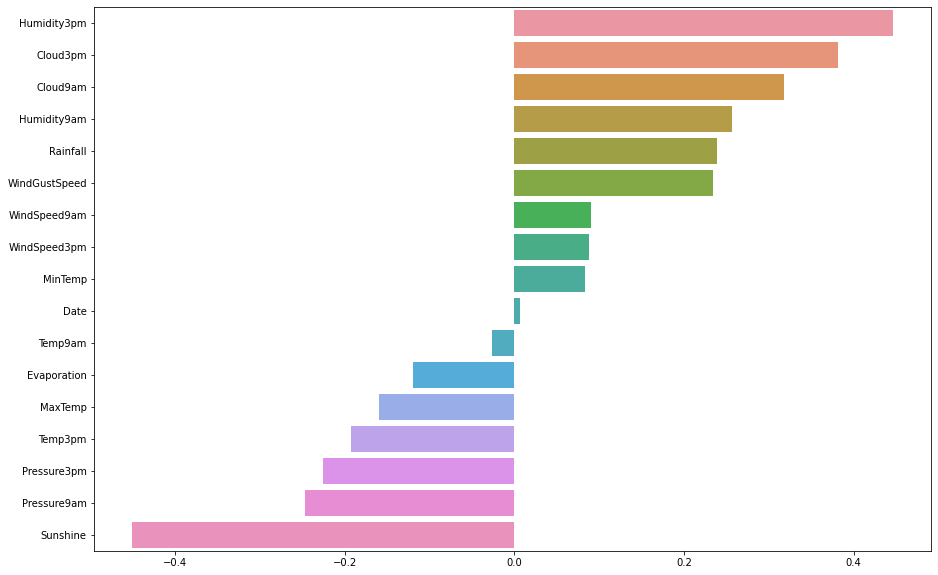

In [7]:
import seaborn as sns
correlations = X[numerical].corrwith(y).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15,10)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

mean = np.mean(X_train[numerical], axis=0)
X_train[numerical] = X_train[numerical].fillna(mean)
X_test[numerical] = X_test[numerical].fillna(mean)

X_train[categorical] = X_train[categorical].fillna('NotGiven')
X_test[categorical] = X_test[categorical].fillna('NotGiven')

было принято решение отказаться от трансформера колонок, в пользу отдельно ординал енкодера, значения которого впоследствие выравниваются стандартный скейлером.

In [11]:
# # imputer почему то не работает.
# column_transformer = ColumnTransformer([                
#   # ('imputer', SimpleImputer(missing_values=np.nan, strategy="mean"), numerical),
#   ('oe', OrdinalEncoder(), categorical),
#   ('scaler', StandardScaler(), all),
#   # ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
# ])

oe = OrdinalEncoder()
scaler = StandardScaler()

Упростим датасет для ван хот енкодера, убрав редко попдающиеся значения признаков.

In [12]:
X_train[categorical] = oe.fit_transform(X_train[categorical])
X_test[categorical] = oe.transform(X_test[categorical])
X_train =scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_dense = X_train
X_test_dense = X_test


### Проверка работоспособности моделей.

Проводить измерения времени исполнения через <i>%%timeit</i> не представляется возможным, поэтому приведу время исполнения данных алгоритмов на гуглдиске.<br>
Логистическая регрессия: 0с<br>
Kneighbours: 1м, 45с<br>
Байес: 0с <br>
Наша реализация: 38с

Далее последует проверка для моделей, из пакета sklearn.

In [13]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Логистическая регрессия.

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=('No Rain', 'Rain')))

              precision    recall  f1-score   support

     No Rain       0.87      0.94      0.90     27604
        Rain       0.72      0.49      0.58      7945

    accuracy                           0.84     35549
   macro avg       0.79      0.72      0.74     35549
weighted avg       0.83      0.84      0.83     35549



KNeighbours

In [ ]:
model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=('No Rain', 'Rain')))

              precision    recall  f1-score   support

     No Rain       0.87      0.93      0.90     27604
        Rain       0.68      0.50      0.57      7945

    accuracy                           0.83     35549
   macro avg       0.77      0.71      0.73     35549
weighted avg       0.82      0.83      0.82     35549



Байес

In [ ]:
model = GaussianNB()
model.fit(X_train_dense, y_train)
y_pred = model.predict(X_test_dense)
print(classification_report(y_test, y_pred, target_names=('No Rain', 'Rain')))

              precision    recall  f1-score   support

     No Rain       0.88      0.86      0.87     27604
        Rain       0.55      0.60      0.58      7945

    accuracy                           0.80     35549
   macro avg       0.72      0.73      0.72     35549
weighted avg       0.81      0.80      0.80     35549



Проверка нашей модели.

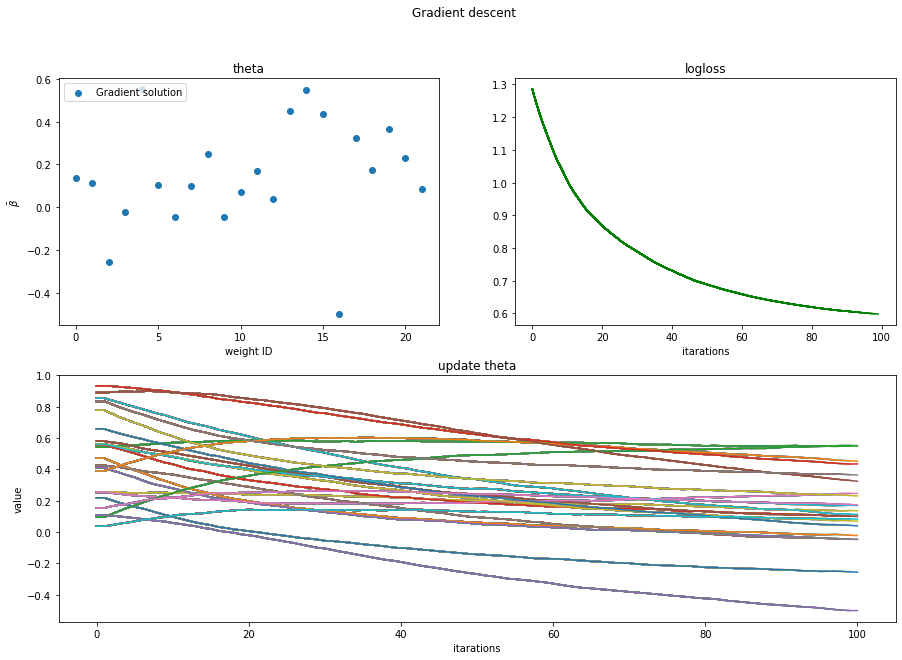

              precision    recall  f1-score   support

     No Rain       0.93      0.66      0.77     27604
        Rain       0.41      0.83      0.55      7945

    accuracy                           0.70     35549
   macro avg       0.67      0.74      0.66     35549
weighted avg       0.81      0.70      0.72     35549



In [ ]:
optimal_theta = fit(X_train_dense, np.array(y_train), batch_size=1000, iters=100, h=0.1)
y_pred = binary_class_prediction(optimal_theta, X_test)
print(classification_report(y_test, y_pred, target_names=('No Rain', 'Rain')))